In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
import cv2
import numpy as np
from glob import glob
from PIL import Image
from scipy.io import loadmat
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
# Importing Data From COCO

from pycocotools import coco, cocoeval, _mask
from pycocotools import mask as maskUtils 
import array
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import os
pylab.rcParams['figure.figsize'] = (8.0, 10.0)
%matplotlib inline


## Creating a TensorFlow Dataset

Training on the entire CIHP dataset with 38,280 images takes a lot of time, hence we will be using
a smaller subset of 200 images for training our model in this example.

In [4]:
CATEGORY_NAMES=['agfields_singleclass']

ANNOTATION_FILE_VAL = '/content/gdrive/MyDrive/SEGMENTATION/256*256/annotations/val2016.json'
ANNOTATION_FILE_TRAIN = '/content/gdrive/MyDrive/SEGMENTATION/256*256/annotations/train2016.json'


In [5]:
coco_train = coco.COCO(ANNOTATION_FILE_TRAIN)
catIds_train = coco_train.getCatIds(catNms=CATEGORY_NAMES);
imgIds_train = coco_train.getImgIds(catIds=catIds_train);
imgDict_train = coco_train.loadImgs(imgIds_train)
len(imgIds_train) , len(catIds_train)

loading annotations into memory...
Done (t=5.86s)
creating index...
index created!


(2236, 1)

In [6]:
coco_val = coco.COCO(ANNOTATION_FILE_VAL)
catIds_val = coco_val.getCatIds(catNms=CATEGORY_NAMES);
imgIds_val = coco_val.getImgIds(catIds=catIds_val);
imgDict_val = coco_val.loadImgs(imgIds_val)
len(imgIds_val) , len(catIds_val)

loading annotations into memory...
Done (t=1.36s)
creating index...
index created!


(559, 1)

In [7]:
from random import shuffle


shuffle(imgIds_train)
shuffle(imgIds_val)

imgIds_train = imgIds_train[0:6000]
imgIds_val = imgIds_val[0:600]


In [8]:
train_images_field = ["COCO_train2016_{0:012d}.jpg".format(ids) for ids in imgIds_train]
val_images_field = ["COCO_val2016_{0:012d}.jpg".format(ids) for ids in imgIds_val]

In [9]:
print(len(train_images_field) , len(val_images_field))

2236 559


In [10]:
train_images_field = ["COCO_train2016_{0:012d}.jpg".format(ids) for ids in imgIds_train]
print(train_images_field)
del_img_train = set(os.listdir("/content/gdrive/MyDrive/SEGMENTATION/256*256/images/train2016")) - set(train_images_field)
for file_name in del_img_train:
  file_name = "/content/gdrive/MyDrive/SEGMENTATION/256*256/images/train2016/" + file_name
  if os.path.exists(file_name):
    os.remove(file_name)

len(os.listdir("/content/gdrive/MyDrive/SEGMENTATION/256*256/images/train2016"))

['COCO_train2016_000000102854.jpg', 'COCO_train2016_000000102499.jpg', 'COCO_train2016_000000100382.jpg', 'COCO_train2016_000000101808.jpg', 'COCO_train2016_000000100421.jpg', 'COCO_train2016_000000102639.jpg', 'COCO_train2016_000000100501.jpg', 'COCO_train2016_000000100132.jpg', 'COCO_train2016_000000101709.jpg', 'COCO_train2016_000000100662.jpg', 'COCO_train2016_000000101969.jpg', 'COCO_train2016_000000102385.jpg', 'COCO_train2016_000000101345.jpg', 'COCO_train2016_000000102670.jpg', 'COCO_train2016_000000100168.jpg', 'COCO_train2016_000000102736.jpg', 'COCO_train2016_000000101865.jpg', 'COCO_train2016_000000101676.jpg', 'COCO_train2016_000000101547.jpg', 'COCO_train2016_000000100896.jpg', 'COCO_train2016_000000101789.jpg', 'COCO_train2016_000000100764.jpg', 'COCO_train2016_000000102311.jpg', 'COCO_train2016_000000102323.jpg', 'COCO_train2016_000000100547.jpg', 'COCO_train2016_000000101877.jpg', 'COCO_train2016_000000100344.jpg', 'COCO_train2016_000000101794.jpg', 'COCO_train2016_000

2236

In [11]:
val_images_field = ["COCO_val2016_{0:012d}.jpg".format(ids) for ids in imgIds_val]
print(val_images_field)
del_img_val = set(os.listdir("/content/gdrive/MyDrive/SEGMENTATION/256*256/images/val2016")) - set(val_images_field)
for file_name in del_img_val:
  file_name = "/content/gdrive/MyDrive/SEGMENTATION/256*256/images/val2016/" + file_name
  if os.path.exists(file_name):
    os.remove(file_name)

len(os.listdir("/content/gdrive/MyDrive/SEGMENTATION/256*256/images/val2016"))

['COCO_val2016_000000102139.jpg', 'COCO_val2016_000000101187.jpg', 'COCO_val2016_000000100700.jpg', 'COCO_val2016_000000102381.jpg', 'COCO_val2016_000000102201.jpg', 'COCO_val2016_000000101296.jpg', 'COCO_val2016_000000102194.jpg', 'COCO_val2016_000000101378.jpg', 'COCO_val2016_000000102702.jpg', 'COCO_val2016_000000100674.jpg', 'COCO_val2016_000000101665.jpg', 'COCO_val2016_000000101825.jpg', 'COCO_val2016_000000100147.jpg', 'COCO_val2016_000000101942.jpg', 'COCO_val2016_000000101167.jpg', 'COCO_val2016_000000101680.jpg', 'COCO_val2016_000000102354.jpg', 'COCO_val2016_000000102944.jpg', 'COCO_val2016_000000102782.jpg', 'COCO_val2016_000000101076.jpg', 'COCO_val2016_000000102558.jpg', 'COCO_val2016_000000100757.jpg', 'COCO_val2016_000000102088.jpg', 'COCO_val2016_000000102036.jpg', 'COCO_val2016_000000101476.jpg', 'COCO_val2016_000000100309.jpg', 'COCO_val2016_000000101703.jpg', 'COCO_val2016_000000102340.jpg', 'COCO_val2016_000000102177.jpg', 'COCO_val2016_000000103393.jpg', 'COCO_val

559

# Data Generator

In [12]:
import os
import sys
import random

import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

seed = 2019

random.seed = seed
np.random.seed = seed 

In [13]:
class DataGen(tf.keras.utils.Sequence):
  
  def __init__(self , path_input , path_mask , batch_size = 16 , image_size = 256):
    
    self.ids = os.listdir(path_input)
    self.path_input = path_input
    self.path_mask = path_mask
    self.batch_size = batch_size
    self.image_size = image_size
    self.on_epoch_end()
  
  def __load__(self , id_name):
    
    image_path = os.path.join(self.path_input , id_name)
    mask_path = os.path.join(self.path_mask , id_name) 
    
    image = cv2.imread(image_path , 1) # 1 specifies RGB format
    image = cv2.resize(image , (self.image_size , self.image_size)) # resizing before inserting to the network
    
    mask = cv2.imread(mask_path , -1)
    mask = cv2.resize(mask , (self.image_size , self.image_size))
    mask = mask.reshape((self.image_size , self.image_size , 1))
      
    #normalize image
    image = image / 255.0
    mask = mask / 255.0
    
    return image , mask
  
  def __getitem__(self , index):
    
    if (index + 1)*self.batch_size > len(self.ids):
      self.batch_size = len(self.ids) - index * self.batch_size
        
    file_batch = self.ids[index * self.batch_size : (index + 1) * self.batch_size]
    
    images = []
    masks = []
    
    for id_name in file_batch : 
      
      _img , _mask = self.__load__(id_name)
      images.append(_img)
      masks.append(_mask)
    
    
    images = np.array(images)
    masks = np.array(masks)
    
    
    return images , masks
  
  
  def on_epoch_end(self):
    pass
  
  
  def __len__(self):
    
    return int(np.ceil(len(self.ids) / float(self.batch_size)))

In [14]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

In [15]:

def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output


In [18]:

def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)


model = DeeplabV3Plus(image_size=256, num_classes=1)
model.summary()

94781440/94765736 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

In [19]:
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [20]:
image_size = 256 
epochs = 50
batch_size = 16


In [23]:
filepath = "/content/gdrive/MyDrive/SEGMENTATION/checkpoint/deeplab+_model.h5"

earlystopper = EarlyStopping(patience=5, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1)

callbacks_list = [earlystopper, checkpoint, reduce_lr]

In [24]:
train_gen = DataGen(path_input = "/content/gdrive/MyDrive/SEGMENTATION/256*256/images/train2016" , path_mask = "/content/gdrive/MyDrive/SEGMENTATION/mask/coco_mask_train2016" , batch_size = batch_size , image_size = image_size)
val_gen = DataGen(path_input =  "/content/gdrive/MyDrive/SEGMENTATION/256*256/images/val2016", path_mask =  "/content/gdrive/MyDrive/SEGMENTATION/mask/coco_mask_val2016", batch_size = batch_size , image_size = image_size)


train_steps =  len(os.listdir( "/content/gdrive/MyDrive/SEGMENTATION/256*256/images/train2016"))/batch_size


model.fit_generator(train_gen , validation_data = val_gen , steps_per_epoch = train_steps , epochs=epochs, verbose = True,  callbacks=callbacks_list)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/50
140/139 [==============================] - ETA: -1s - loss: 1.0414 - accuracy: 0.5433
Epoch 1: val_loss improved from inf to 7.55359, saving model to /content/gdrive/MyDrive/SEGMENTATION/checkpoint/deeplab+_model.h5
139/139 [==============================] - 1392s 10s/step - loss: 1.0414 - accuracy: 0.5433 - val_loss: 7.5536 - val_accuracy: 0.3989 - lr: 1.0000e-04
Epoch 2/50
140/139 [==============================] - ETA: 0s - loss: 0.6826 - accuracy: 0.6070
Epoch 2: val_loss improved from 7.55359 to 7.20864, saving model to /content/gdrive/MyDrive/SEGMENTATION/checkpoint/deeplab+_model.h5
139/139 [==============================] - 138s 992ms/step - loss: 0.6826 - accuracy: 0.6070 - val_loss: 7.2086 - val_accuracy: 0.4316 - lr: 1.0000e-04
Epoch 3/50
140/139 [==============================] - ETA: 0s - loss: 0.6563 - accuracy: 0.6229
Epoch 3: val_loss improved from 7.20864 to 1.14507, saving model to /content/gdrive/MyDrive/SEGMENTATION/checkpoint/deeplab+_model.h5
139/139 [=

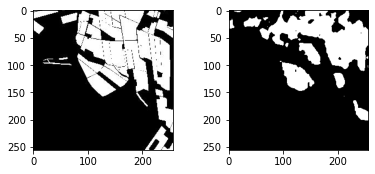

In [25]:
x, y = val_gen.__getitem__(6)
result = model.predict(x)

result = result > 0.5



fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

## Inference using Colormap Overlay

The raw predictions from the model represent a one-hot encoded tensor of shape `(N, 512, 512, 20)`
where each one of the 20 channels is a binary mask corresponding to a predicted label.
In order to visualize the results, we plot them as RGB segmentation masks where each pixel
is represented by a unique color corresponding to the particular label predicted. We can easily
find the color corresponding to each label from the `human_colormap.mat` file provided as part
of the dataset. We would also plot an overlay of the RGB segmentation mask on the input image as
this further helps us to identify the different categories present in the image more intuitively.

In [ ]:
# Loading the Colormap
colormap = loadmat(
    "./instance-level_human_parsing/instance-level_human_parsing/human_colormap.mat"
)["colormap"]
colormap = colormap * 100
colormap = colormap.astype(np.uint8)


def infer(model, image_tensor):
    predictions = model.predict(np.expand_dims((image_tensor), axis=0))
    predictions = np.squeeze(predictions)
    predictions = np.argmax(predictions, axis=2)
    return predictions


def decode_segmentation_masks(mask, colormap, n_classes):
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    for l in range(0, n_classes):
        idx = mask == l
        r[idx] = colormap[l, 0]
        g[idx] = colormap[l, 1]
        b[idx] = colormap[l, 2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb


def get_overlay(image, colored_mask):
    image = tf.keras.preprocessing.image.array_to_img(image)
    image = np.array(image).astype(np.uint8)
    overlay = cv2.addWeighted(image, 0.35, colored_mask, 0.65, 0)
    return overlay


def plot_samples_matplotlib(display_list, figsize=(5, 3)):
    _, axes = plt.subplots(nrows=1, ncols=len(display_list), figsize=figsize)
    for i in range(len(display_list)):
        if display_list[i].shape[-1] == 3:
            axes[i].imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        else:
            axes[i].imshow(display_list[i])
    plt.show()


def plot_predictions(images_list, colormap, model):
    for image_file in images_list:
        image_tensor = read_image(image_file)
        prediction_mask = infer(image_tensor=image_tensor, model=model)
        prediction_colormap = decode_segmentation_masks(prediction_mask, colormap, 20)
        overlay = get_overlay(image_tensor, prediction_colormap)
        plot_samples_matplotlib(
            [image_tensor, overlay, prediction_colormap], figsize=(18, 14)
        )


### Inference on Train Images

In [ ]:
plot_predictions(train_images[:4], colormap, model=model)

### Inference on Validation Images

In [ ]:
plot_predictions(val_images[:4], colormap, model=model)